In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00


#import necessary packages and data

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 21.2 MB/s eta 0:00:00


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,StratifiedKFold
from scipy.stats import boxcox, median_abs_deviation
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest

import shap 
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/playground-series-s3e3/train.csv", index_col = 0)
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/playground-series-s3e3/test.csv", index_col = 0)
sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/playground-series-s3e3/sample_submission.csv",index_col = 0)

*set parameters*

In [6]:
target = "Attrition"

sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

#Data expolaration

##Basic Exploratory Data Analysis

In [7]:
df_train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


In [8]:
df_train[target].head()

id
0    0
1    0
2    0
3    0
4    1
Name: Attrition, dtype: int64

In [9]:
print("Unique datatypes:\n",df_train.dtypes.unique())

Unique datatypes:
 [dtype('int64') dtype('O')]


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 0 to 1676
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1677 non-null   int64 
 1   BusinessTravel            1677 non-null   object
 2   DailyRate                 1677 non-null   int64 
 3   Department                1677 non-null   object
 4   DistanceFromHome          1677 non-null   int64 
 5   Education                 1677 non-null   int64 
 6   EducationField            1677 non-null   object
 7   EmployeeCount             1677 non-null   int64 
 8   EnvironmentSatisfaction   1677 non-null   int64 
 9   Gender                    1677 non-null   object
 10  HourlyRate                1677 non-null   int64 
 11  JobInvolvement            1677 non-null   int64 
 12  JobLevel                  1677 non-null   int64 
 13  JobRole                   1677 non-null   object
 14  JobSatisfaction         

In [11]:
df_train.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,2.791890,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,1.097396,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,2.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,3.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,4.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,4.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


In [12]:
print("Null values: \nTrain:", df_train.isnull().sum().sum(), "\nTest:",df_test.isnull().sum().sum())

Null values: 
Train: 0 
Test: 0


**Notes on Basic Exploratory Data Analysis**
>=--->No null values.<br/>
>=--->Categorical data ==> we would need to encode this categorical data<br/>
>=--->Using df.describe() is hard to understand the data with so many columns and without visualisation.



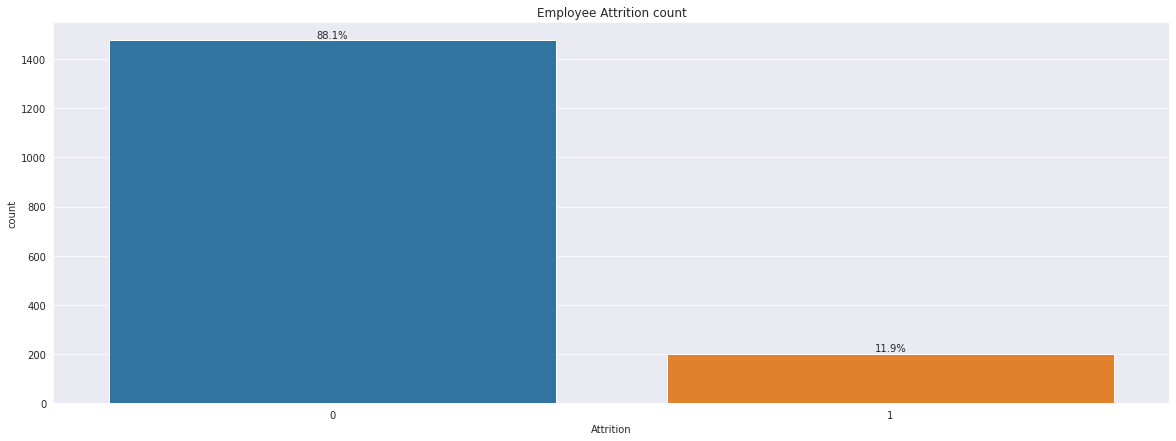

In [13]:
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(x= df_train[target])
plt.title("Employee Attrition count")

total = len(df_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

>we can see that there is class imbalance (Attrition==1 where the employee <br/>
>leaves the company >> Attrition==0)

##Check data distribution

In [14]:
numerical = [col for col in df_train.select_dtypes("int64").columns if col not in [target, 'EmployeeCount']]
categorical = [col for col in df_train.select_dtypes("object").columns if col!=target]

***categorical data***

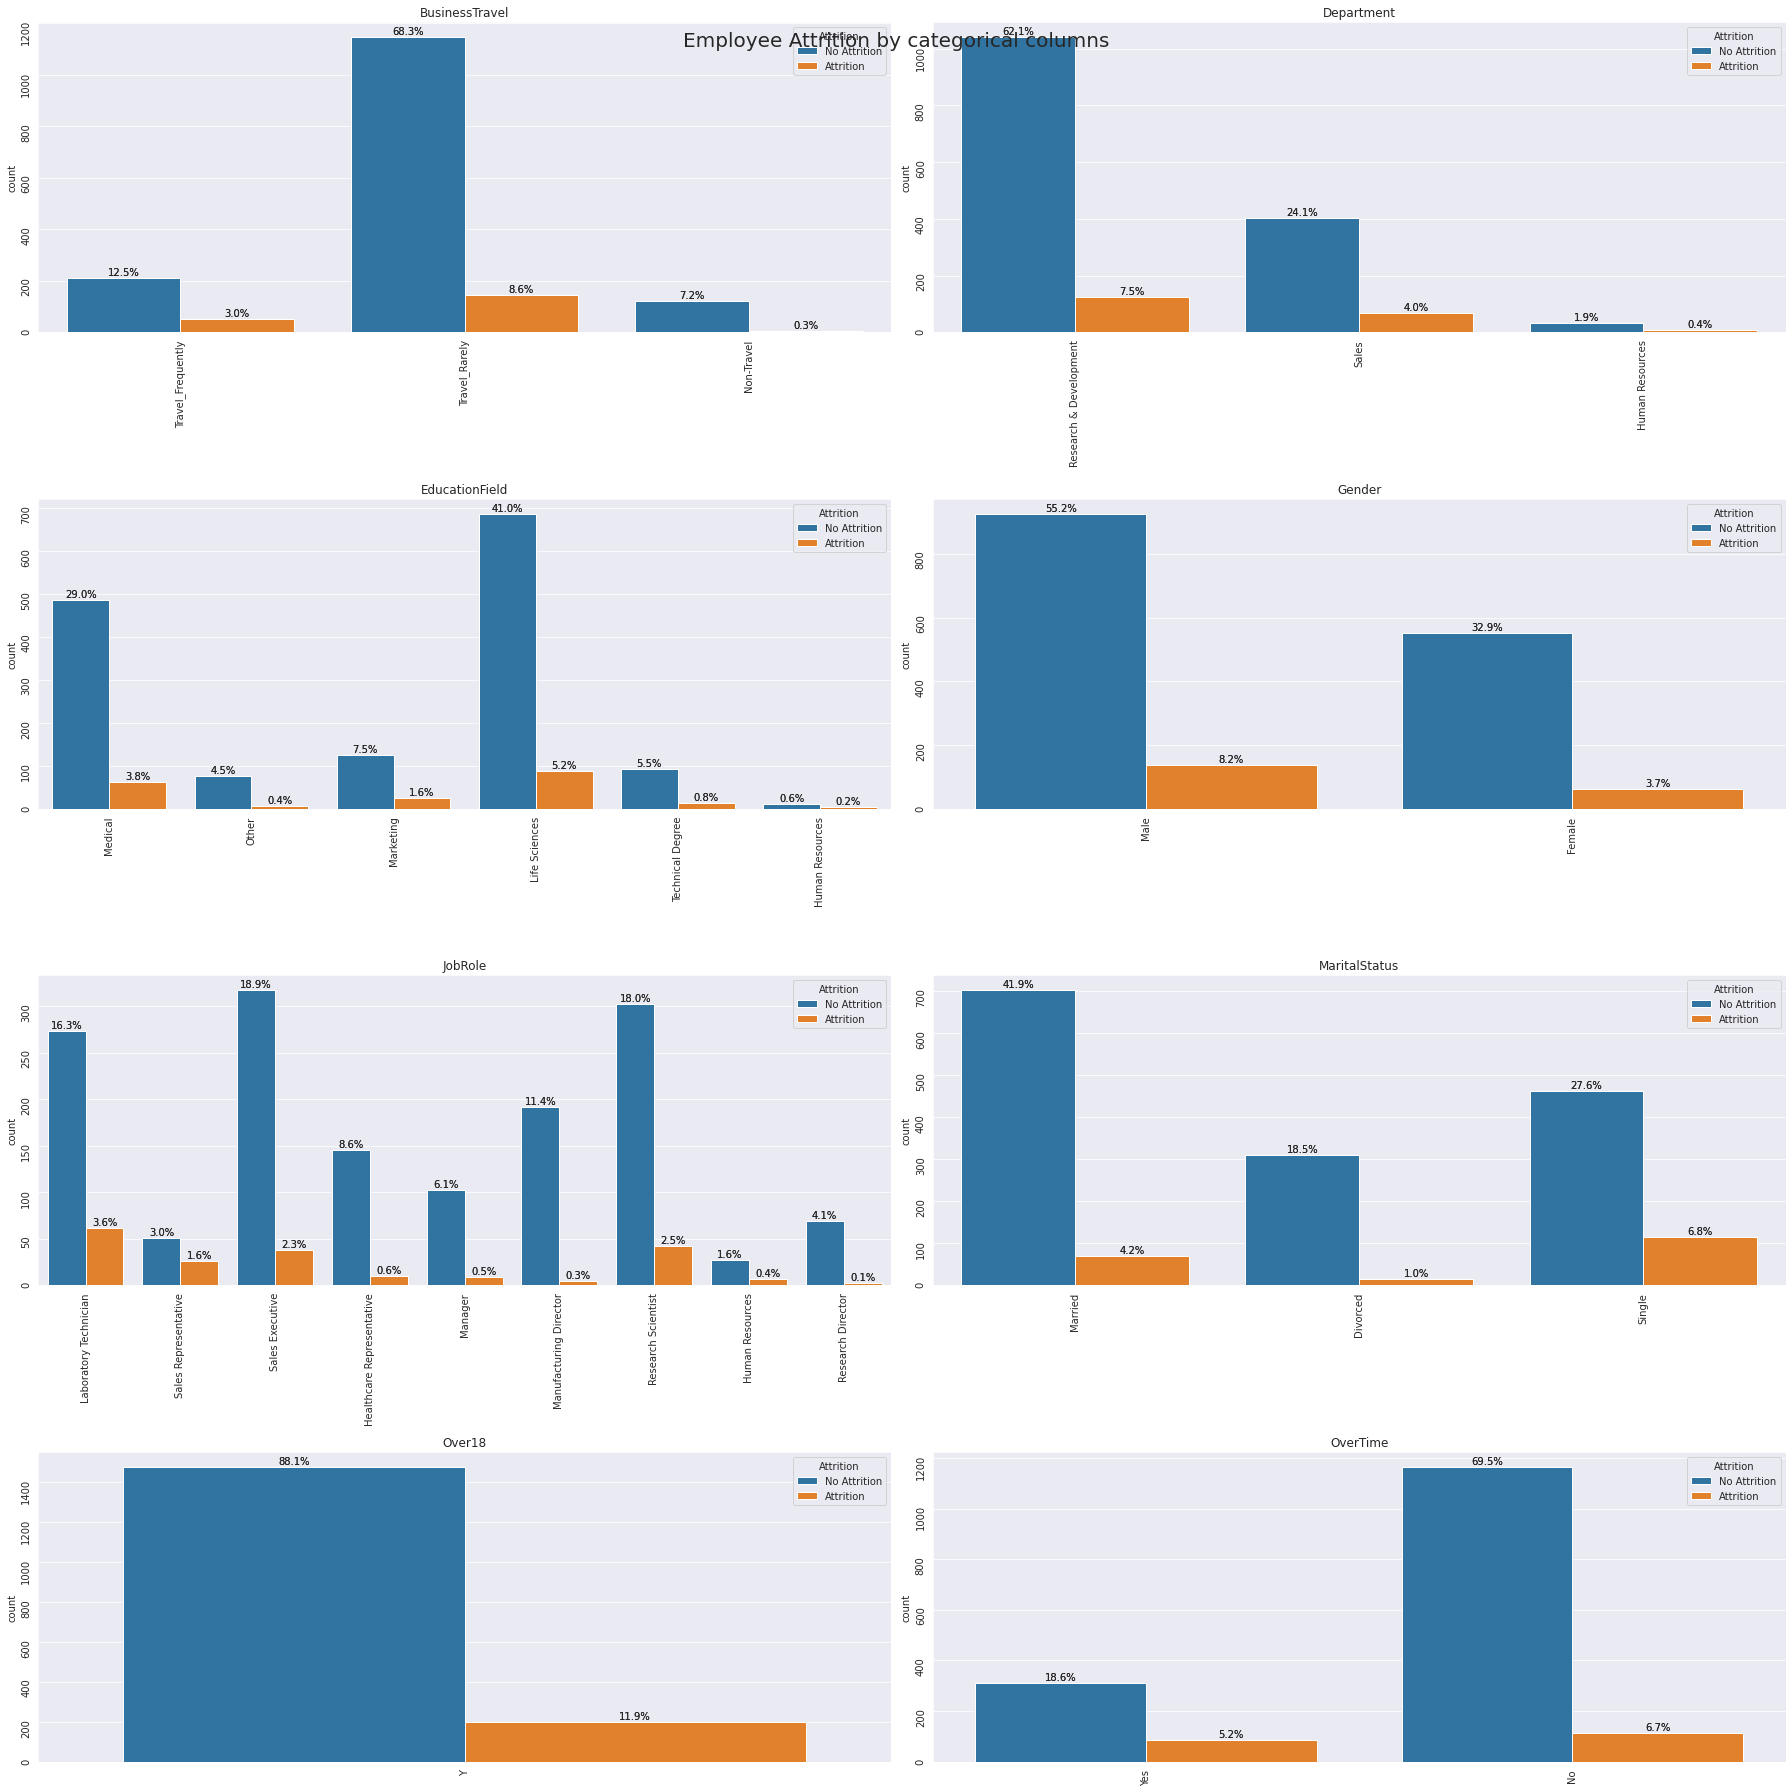

In [15]:
fig,ax = plt.subplots(4,2,figsize = (25,25))
total = len(df_train)
ax = np.ravel(ax)

for i,col in enumerate(categorical):
    sns.countplot(ax = ax[i],x = df_train[col], hue=df_train[target])
    sns.countplot(ax = ax[i],x = df_train[col], hue=df_train[target])
    ax[i].tick_params(labelrotation=90)
    ax[i].set_title(f"{col}",fontsize = 12)
    ax[i].legend(title='Attrition', loc='upper right', labels=['No Attrition', 'Attrition'])
    ax[i].set(xlabel=None)
    
    for p in ax[i].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax[i].annotate(percentage, (x, y), ha='center', va='center')
    
fig.suptitle("Employee Attrition by categorical columns",fontsize = 20)
plt.tight_layout()
plt.show()

***numerical data (distribution)***

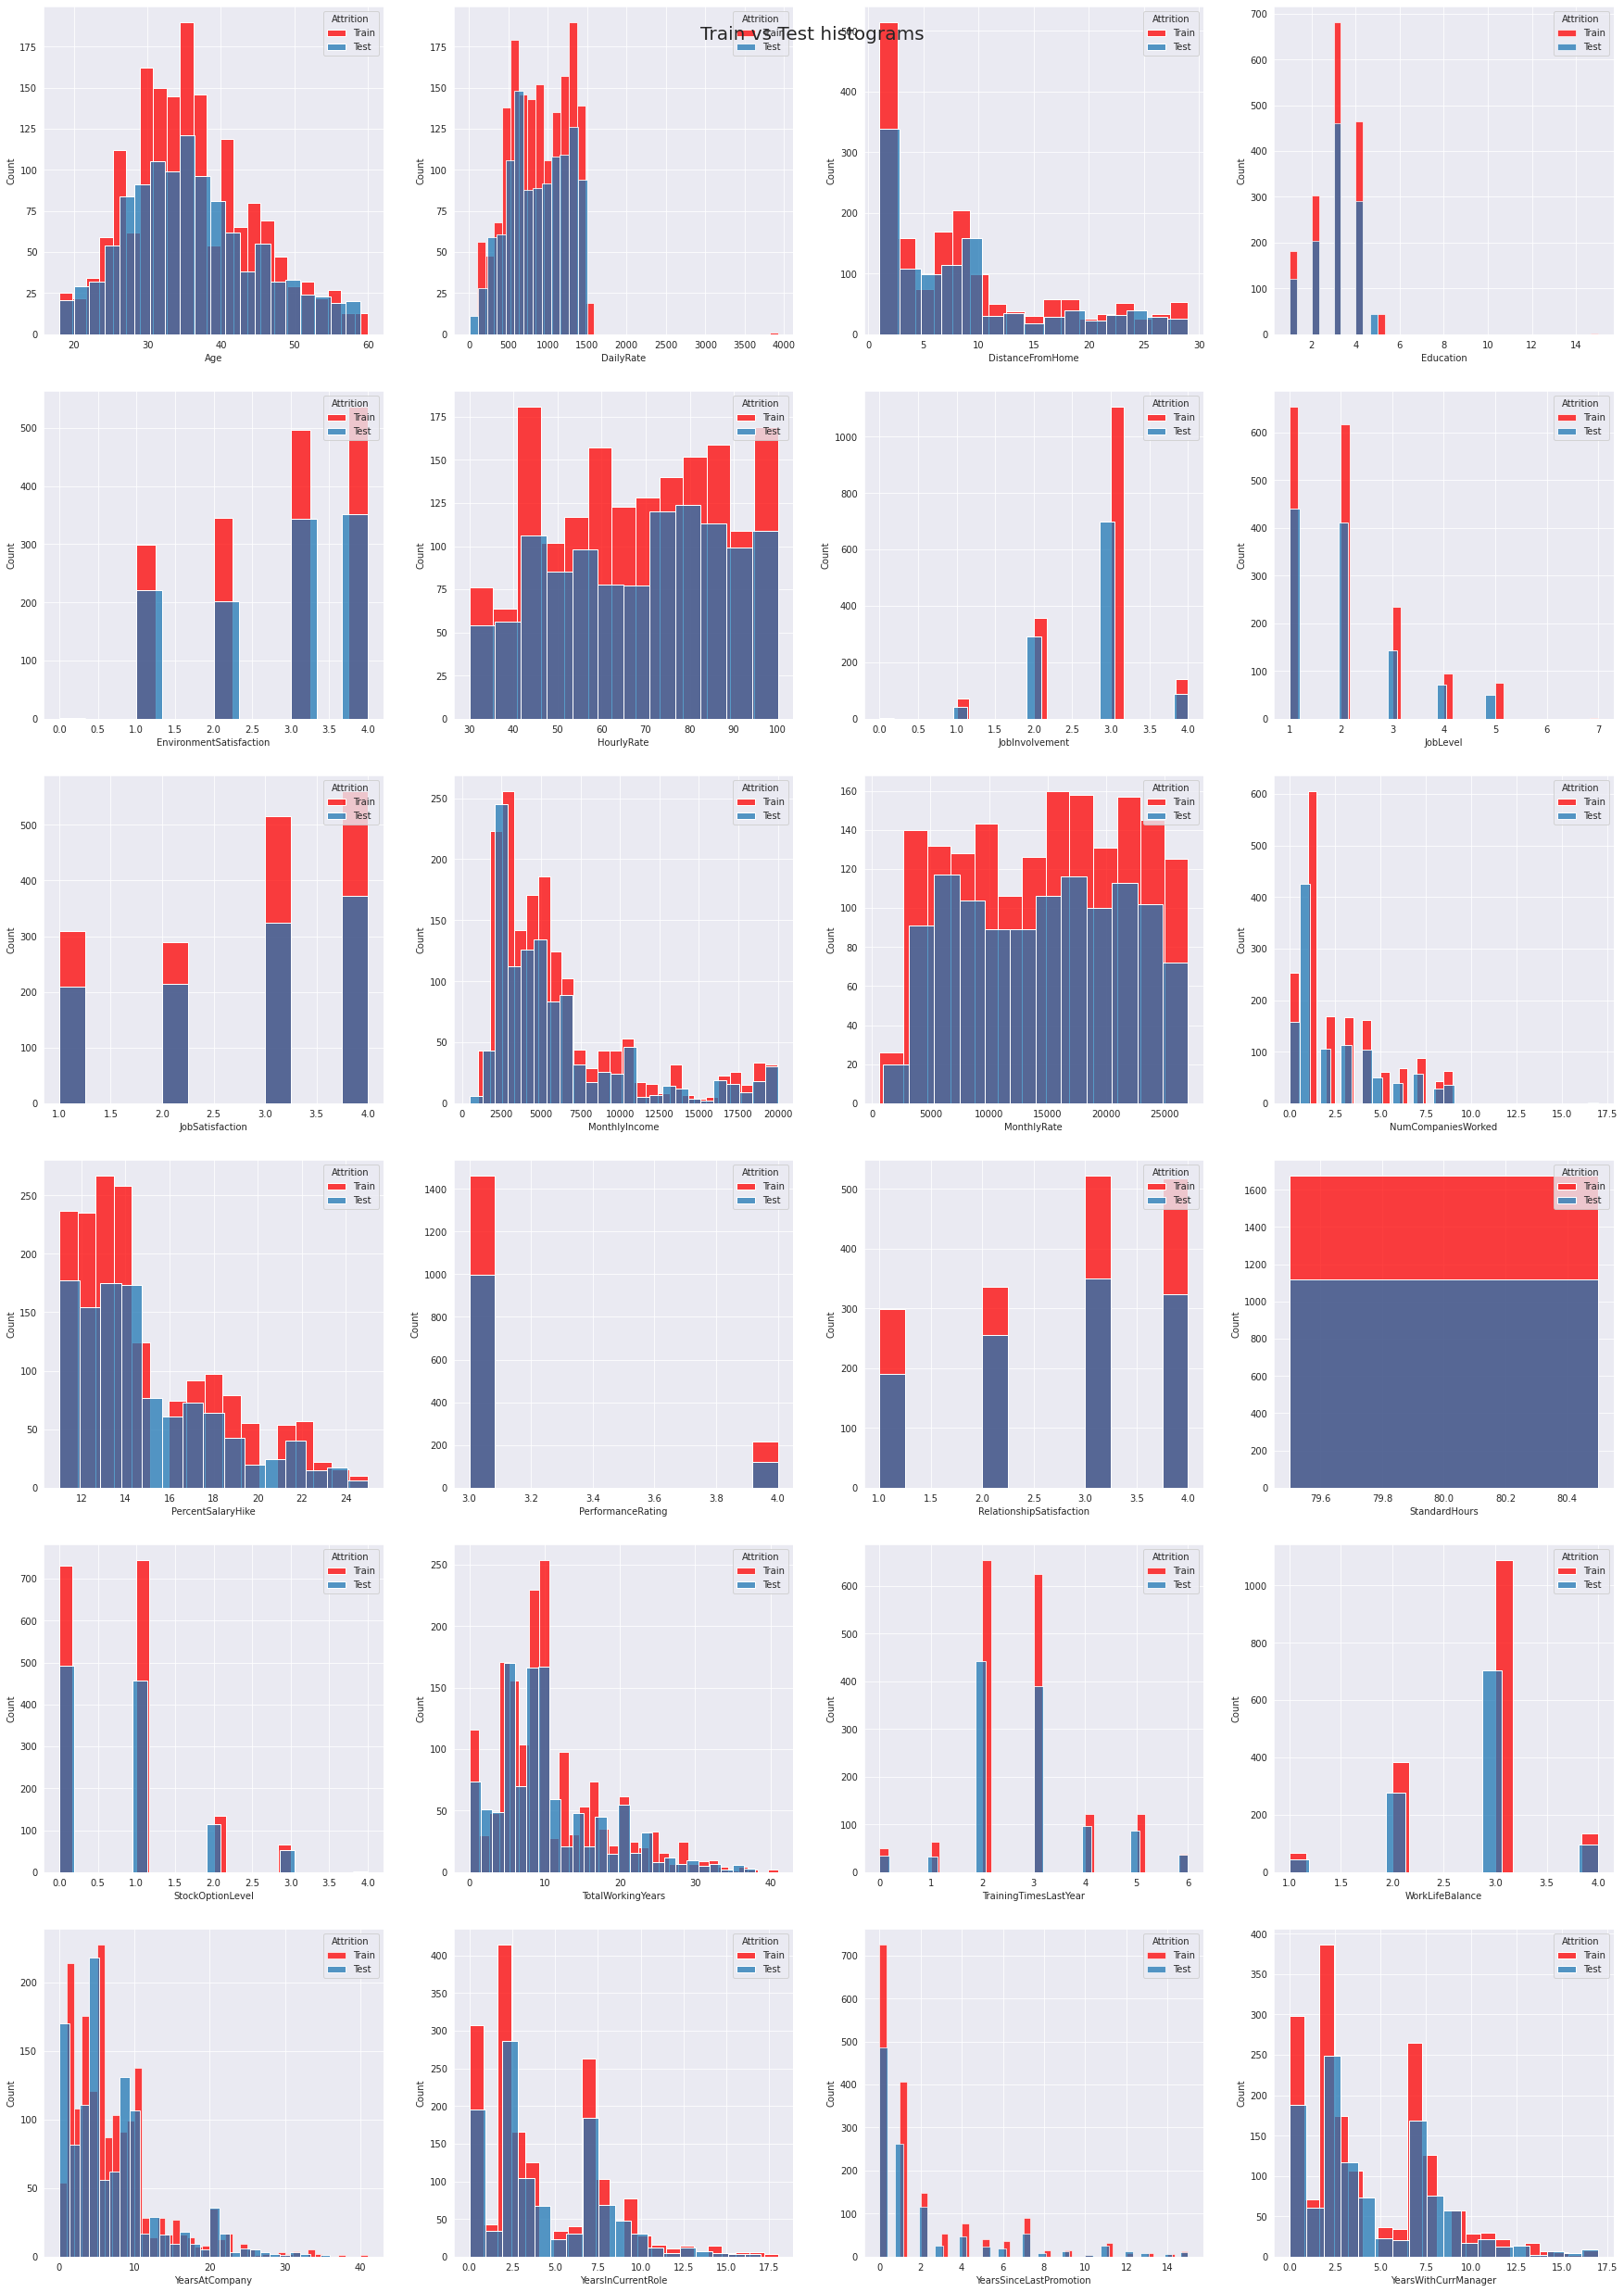

In [16]:
fig,ax = plt.subplots(6,4,figsize = (25,35))
ax = np.ravel(ax)

for i,col in enumerate(numerical):
    sns.histplot(ax = ax[i], x = df_train[col], label = "Train", color= "red")
    sns.histplot(ax = ax[i], x = df_test[col], label = "Test")

    ax[i].legend(title='Attrition', loc='upper right', labels=['Train', 'Test'])
    
fig.suptitle("Train vs Test histograms",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

**Skewness**<br/>
Skewness is a measure of how "off" the data is to being normally distrubuted i.e its skewness<br/>
>Skewness > 1 = highly positively skewed<br/>
>Skewness < -1 = highly negatively skewed<br/>
>Skewness close to 0 = Normally distributed<br/>

In [17]:
# We concatenate test data to train to get a full view of the data as we know it
skew_df = pd.concat((df_train.drop(target,axis =1), df_test), axis =0).skew(numeric_only=True).sort_values()
skew_df

JobInvolvement             -0.638101
WorkLifeBalance            -0.593399
JobSatisfaction            -0.399820
EnvironmentSatisfaction    -0.349869
RelationshipSatisfaction   -0.325142
HourlyRate                 -0.138004
MonthlyRate                -0.050417
EmployeeCount               0.000000
StandardHours               0.000000
DailyRate                   0.051458
Education                   0.263171
Age                         0.442954
TrainingTimesLastYear       0.585246
YearsWithCurrManager        0.854522
YearsInCurrentRole          0.887307
PercentSalaryHike           0.956236
StockOptionLevel            1.030114
DistanceFromHome            1.065300
TotalWorkingYears           1.151811
JobLevel                    1.159103
NumCompaniesWorked          1.167325
MonthlyIncome               1.564419
YearsAtCompany              1.652342
YearsSinceLastPromotion     2.081346
PerformanceRating           2.337493
dtype: float64

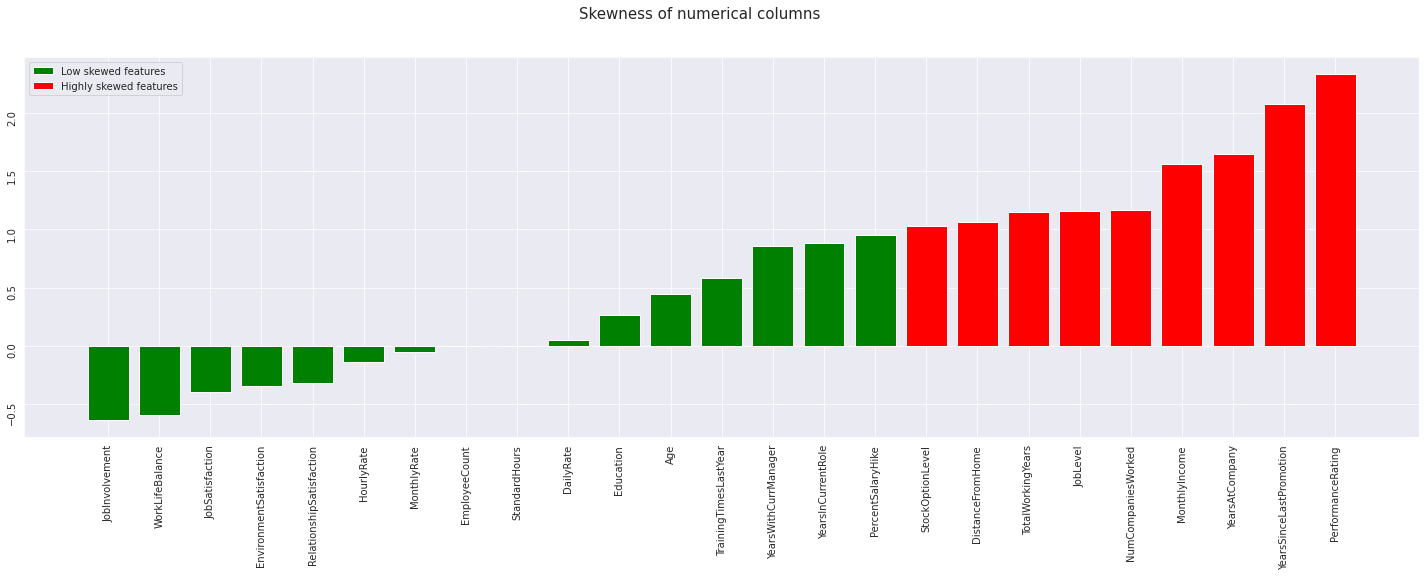

In [18]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = skew_df[(skew_df<1)& (skew_df>-1)].index, height = skew_df[(skew_df<1)& (skew_df>-1)], color = "g", label= "Low skewed features")
ax.bar(x = skew_df[skew_df>1].index, height = skew_df[skew_df>1], color = "r", label = "Highly skewed features")
ax.bar(x = skew_df[skew_df<-1].index, height = skew_df[skew_df<-1], color = "b")
ax.legend()
fig.suptitle("Skewness of numerical columns",fontsize = 15)
ax.tick_params(labelrotation=90)

**Distribution Transformations:** <br/>
linear models needs normally distributed data </br>
so we have to apply some transformations to our data <br/>
to become normaly distributed some of this transformations include:<br/>

=-->Log transform<br/>
=-->Scaling (Quantile)<br/>
=-->BoxCox<br/>
=-->Cube root / Square root<br/>

In [19]:
skew_cols = list(skew_df.index)
print("List of skew columns\n")
skew_cols

List of skew columns



['JobInvolvement',
 'WorkLifeBalance',
 'JobSatisfaction',
 'EnvironmentSatisfaction',
 'RelationshipSatisfaction',
 'HourlyRate',
 'MonthlyRate',
 'EmployeeCount',
 'StandardHours',
 'DailyRate',
 'Education',
 'Age',
 'TrainingTimesLastYear',
 'YearsWithCurrManager',
 'YearsInCurrentRole',
 'PercentSalaryHike',
 'StockOptionLevel',
 'DistanceFromHome',
 'TotalWorkingYears',
 'JobLevel',
 'NumCompaniesWorked',
 'MonthlyIncome',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'PerformanceRating']

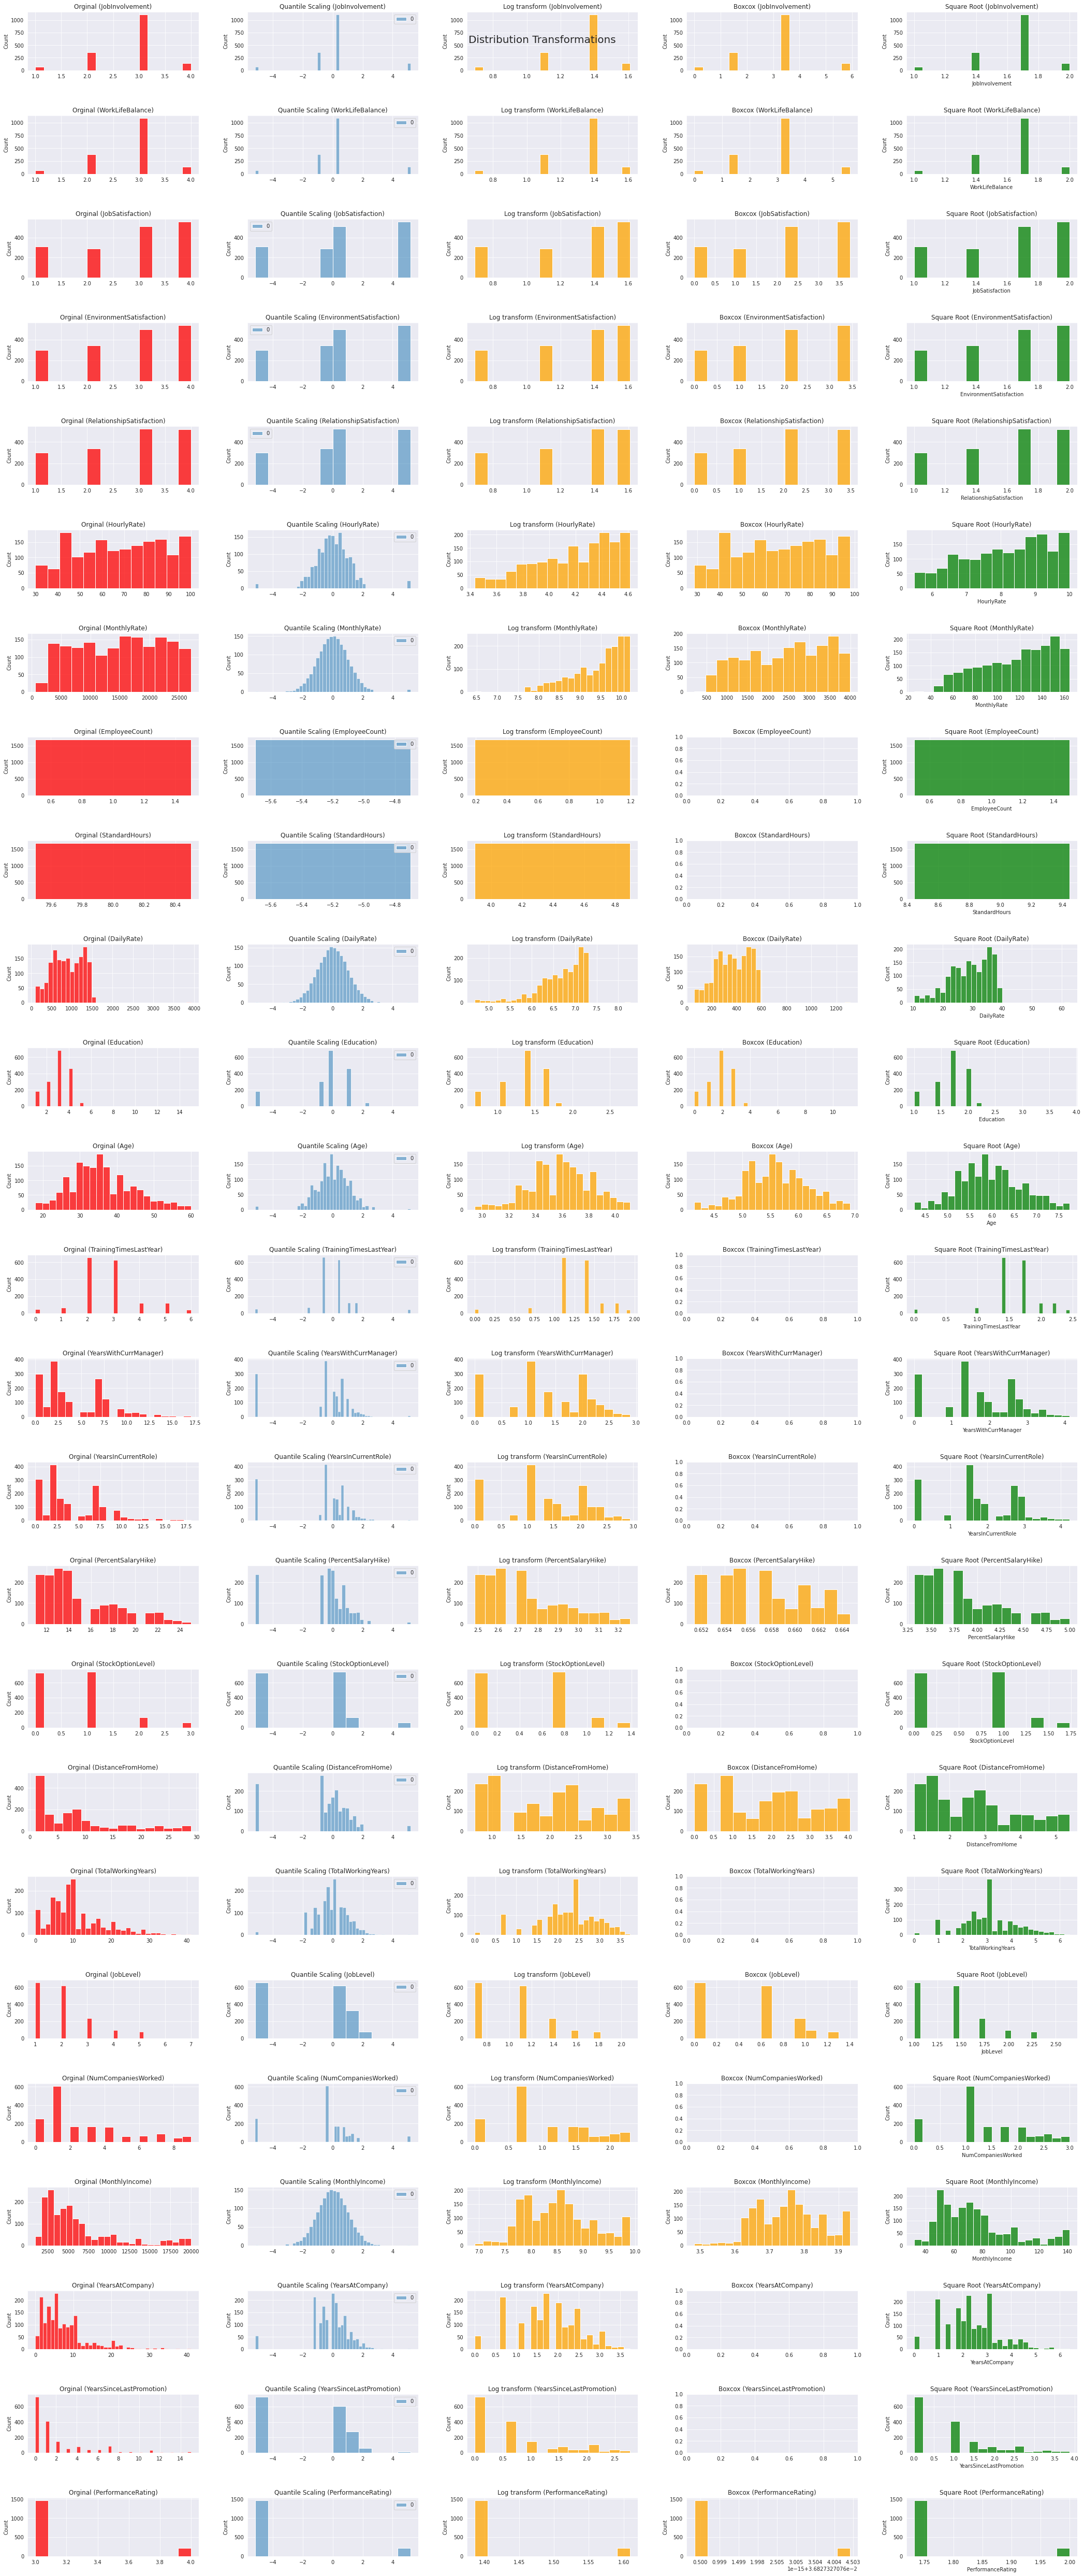

In [20]:
fig,ax = plt.subplots(len(skew_cols),5, figsize = (30,70))
for i,col in enumerate(skew_cols):
    
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(df_train[[col]])

    sns.histplot(x= df_train[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(df_train[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(df_train[col])[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(df_train[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 20)
plt.tight_layout(pad = 4)
plt.show()

**Notes on Distribution:**

>We are looking to create a normally distributed graph<br/>
>we can see that QuantileTransform is the most technique to do so<br/>
**Remove none skew features**: <br/>
We will remove:

>"StandardHours","EmployeeCount" --> 0 skewness<br/>
>"Performance Rating" --> not able to improve distribution<br/>

In [21]:
#remove low skewness 
for i in ["StandardHours","EmployeeCount", "PerformanceRating"]:
    skew_cols.remove(i)

**Correlation & Mututal Information of features**<br/>
>Features which are correlated can affect some models and  cause overfitting.

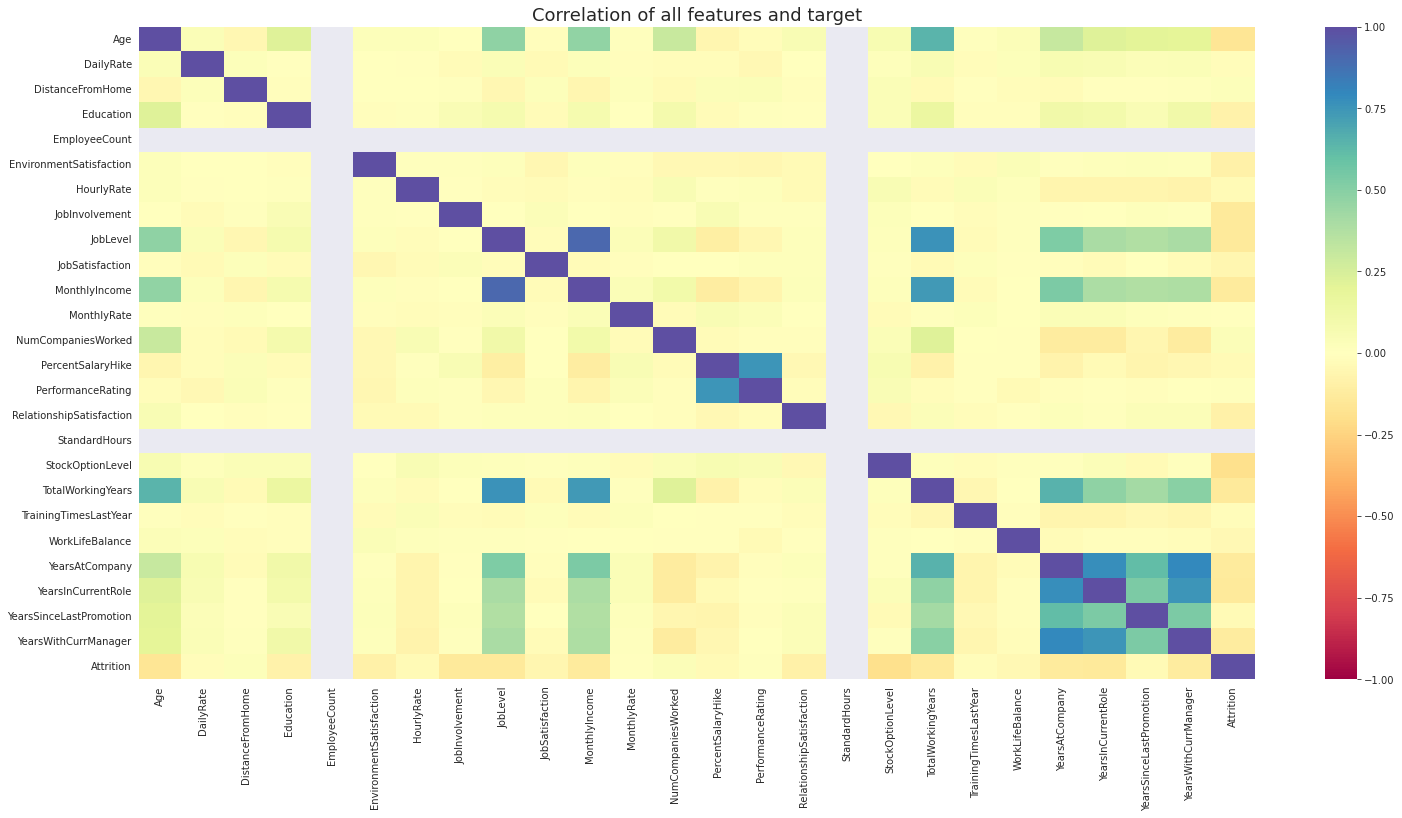

In [22]:
plt.figure(figsize = (25,12))
sns.heatmap(df_train.corr(),vmin = -1, vmax = 1, cmap = "Spectral")
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()


**Notes on Correlation:**<br/>

>Little / No corelation between features and target<br>
>Major correlation in "TotalWorkingYears" and other "Year..." features

# Feauture Engineering

##Feature Selection

**Mutual Information**<br/>
>Mutual information (MI) measures the dependecy of features to the target.<br/><br/>
=--->Positive values are show a dependecy between the feature and the target i.e. the feature is important to the target and its predictions<br/>
<br/>
>=--->Values equal to zero shows independency to the target and are less important to target predictions

In [23]:
from sklearn.feature_selection import SelectKBest

In [24]:
 # feature selection
def select_features(df):
    df_trn = pd.get_dummies(df_train,drop_first =True) #onehotencoding needed for categorical columns 
    X_train, X_test, y_train, y_test = train_test_split(df_trn.drop(target,axis =1), df_trn[target], test_size=0.33, random_state=1) 
    
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    columns = X_train.columns
    return X_train_fs, X_test_fs, fs, columns 

# feature selection
X_train_fs, X_test_fs, fs, columns = select_features(df_train)

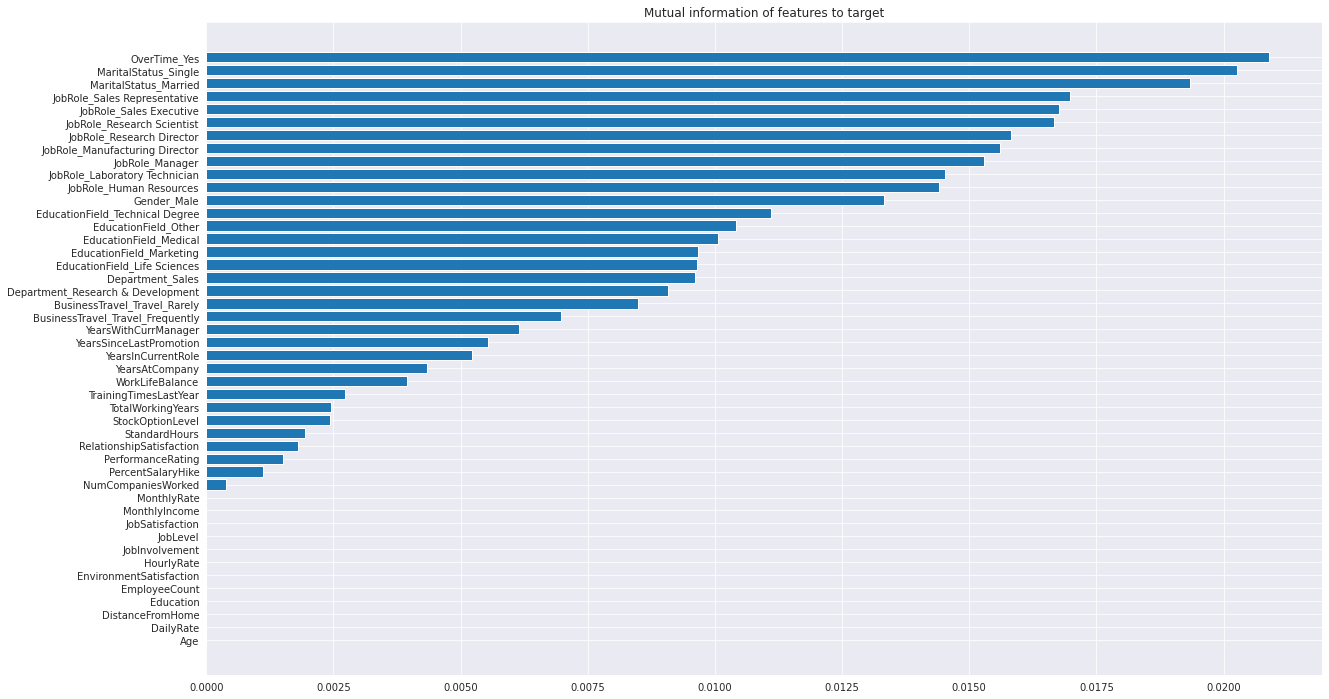

In [25]:
selected_feats = pd.DataFrame(fs.scores_, index = columns).sort_values(by = 0 , ascending = True)

fig,ax = plt.subplots(figsize =(20,12))
plt.barh(y =columns, width= selected_feats[0])
plt.title("Mutual information of features to target")
plt.show()

**Notes on Dependency**

>=--->We can conclude that certain features are highly dependent on our Target(i.e. OverTime_Yes). We should potentially look to apply feature engineering to these features, so as to further improve our model accuracy.<br/><br/>

>=--->There is little to no mutual information for certain columns on the target, where mutual information =0 (e.g. Age, DailyRate). We should note these down for potential removal. However we will run our base model to confirm the feature importance and compare the two output<br/><br/>

##Outliers / Distribution 

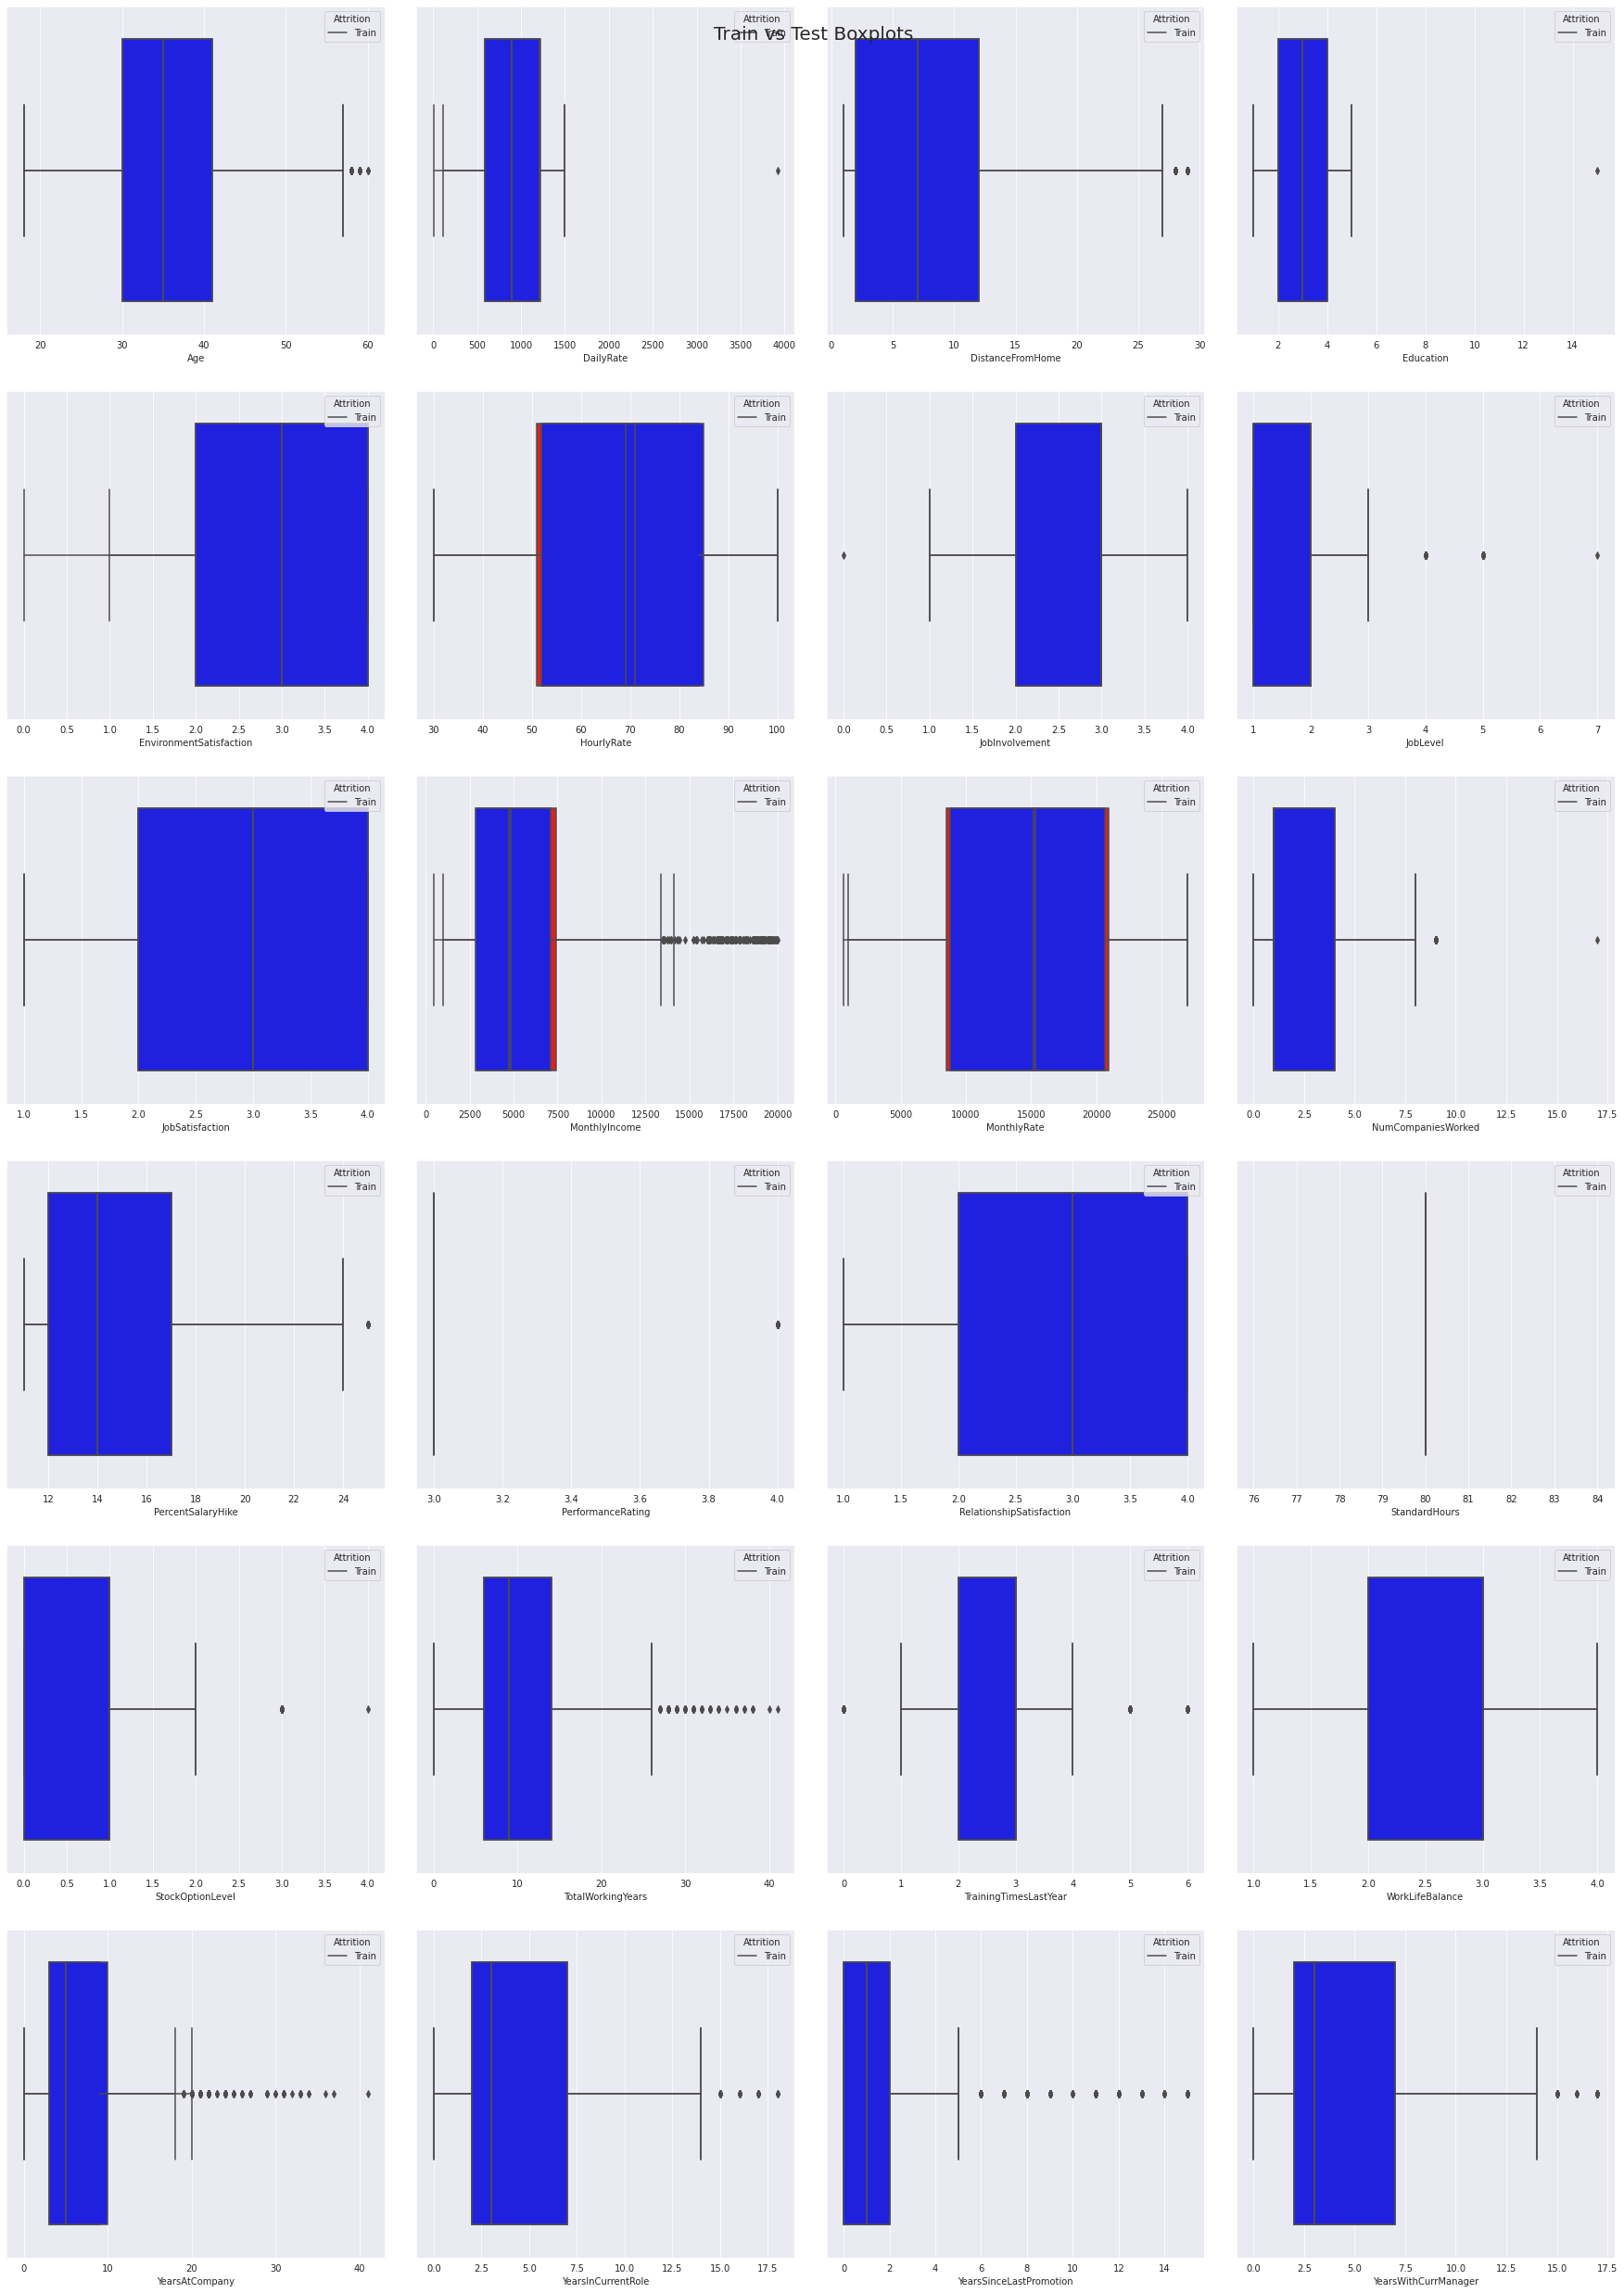

In [26]:
fig,ax = plt.subplots(6,4,figsize = (25,35))
ax = np.ravel(ax)

for i,col in enumerate(numerical):
    sns.boxplot(ax = ax[i], x = df_train[col], color= "red")
    sns.boxplot(ax = ax[i], x = df_test[col], color= "blue")

    ax[i].legend(title='Attrition', loc='upper right', labels=['Train'])
    
fig.suptitle("Train vs Test Boxplots",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

**Notes: Columns with outliers**<br/>

YearsAtCompany<br/>
YearsInCurrentRole<br/>
YearsSinceLastPromotion<br/>
YearsWithCurrManager<br/>
TotalWorkingYears<br/>
MonthlyIncome (NB also in skewness -> potential conflict)

**Potential Solutions**<br/>
some of the solutions include *Scaling*(RobustScaler)

In [27]:
outliers = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TotalWorkingYears']

let's now add the original data

In [28]:
add_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/playground-series-s3e3/WA_Fn-UseC_-HR-Employee-Attrition.csv').drop('EmployeeNumber',axis =1)

df_train['is_generated'] = 1
df_test['is_generated'] = 1
add_data['is_generated'] = 0

add_data["Attrition"]=add_data["Attrition"].map({"Yes":1, "No":0})
df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,is_generated
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,1,10,2,3,10,0,7,8,0,1
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,1,4,3,3,4,2,0,3,0,1
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,2,4,3,3,3,2,1,2,0,1
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,0,15,1,1,6,0,0,2,0,1
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,0,31,0,3,31,14,4,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,36,Travel_Frequently,884,Research & Development,23,2,Medical,1,3,Male,...,1,17,3,3,5,2,0,3,0,0
3143,39,Travel_Rarely,613,Research & Development,6,1,Medical,1,4,Male,...,1,9,5,3,7,7,1,7,0,0
3144,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2,Male,...,1,6,0,3,6,2,0,3,0,0
3145,49,Travel_Frequently,1023,Sales,2,3,Medical,1,4,Male,...,0,17,3,2,9,6,0,8,0,0


##Encoding

Potential solutions
<ul>
<li>Onehotencoding </li>
<li>WOEencoder </li>
 <li>LabelEncoder</li>
</ul>

In [29]:
df_trn = pd.get_dummies(df_train,drop_first =True)
df_tst = pd.get_dummies(df_test,drop_first =True)
df_trn.keys()


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition', 'is_generated', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Di

**Split**

In [30]:
X = df_trn.drop([target],axis =1)
y = df_trn[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Modelling

In [31]:

def Scaling(X_trn, X_tst, test_df, X_in= None,OUTLIERS=False,DISTRIBUTION=False,SCALING=False) : 
    test_s = test_df.copy(deep = True)
    X_train_s = X_trn.copy(deep = True)
    X_test_s = X_tst.copy(deep = True)
    if X is not None:
        X_s = X_in.copy(deep = True)
    
    if OUTLIERS and len(outliers)>0:
        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train_s[outliers] = scaler.fit_transform(X_train_s[outliers])
        X_test_s[outliers]  = scaler.transform(X_test_s[outliers])
        test_s[outliers] = scaler.transform(test_s[outliers])
        if X is not None:
            X_s[outliers] = scaler.transform(X_s[outliers])
    
    if DISTRIBUTION:
        #Scale Skewness: see distribution
        scaler = QuantileTransformer(output_distribution="normal")
        X_train_s = scaler.fit_transform(X_train_s)
        X_test_s = scaler.transform(X_test_s)
        test_s = scaler.transform(test_s)
        if X is not None:
            X_s = scaler.transform(X_s)
            
    if SCALING: 
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train_s)
        X_test_s = scaler.transform(X_test_s)
        test_s = scaler.transform(test_s)
        if X is not None:
            X_s = scaler.transform(X_s)
            
    if X is not None:
        return pd.DataFrame(X_train_s, columns = X_in.columns )   , pd.DataFrame(X_test_s, columns = X_in.columns ) , pd.DataFrame(test_s, columns = test_df.columns ) , pd.DataFrame(X_s, columns = X.columns )  
    else:
        return pd.DataFrame(X_train_s, columns = X_in.columns ), pd.DataFrame(X_test_s, columns = X_in.columns )  , pd.DataFrame(test_s, columns = test_df.columns )

In [32]:
import logging


In [33]:
model= lgb.LGBMClassifier(n_estimators= 1000)

X_train_s, X_test_s , test_temp, X_temp = Scaling(X_train, X_test , df_tst, X )

model.fit(X_train_s,y_train,
          eval_set=[(X_test_s,y_test)],
          eval_metric=["auc"],
          callbacks= [ lgb.early_stopping(30)])

y_preds = model.predict_proba(X_test_s)[:,1]
y_trn_preds = model.predict_proba(X_temp)[:,1]
test_base = model.predict_proba(test_temp)[:,1]

auc_val = roc_auc_score(y_test,y_preds)
auc_trn = roc_auc_score(y,y_trn_preds)

print("\nTrn AUC:",auc_trn)
print("Val AUC:",auc_val)
print("Val logloss", log_loss(y,y_trn_preds))

[1]	valid_0's binary_logloss: 0.395209	valid_0's auc: 0.710829
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.382564	valid_0's auc: 0.731744
[3]	valid_0's binary_logloss: 0.374139	valid_0's auc: 0.749003
[4]	valid_0's binary_logloss: 0.365875	valid_0's auc: 0.757818
[5]	valid_0's binary_logloss: 0.360102	valid_0's auc: 0.764972
[6]	valid_0's binary_logloss: 0.353499	valid_0's auc: 0.782272
[7]	valid_0's binary_logloss: 0.348356	valid_0's auc: 0.781087
[8]	valid_0's binary_logloss: 0.344394	valid_0's auc: 0.779445
[9]	valid_0's binary_logloss: 0.341536	valid_0's auc: 0.786228
[10]	valid_0's binary_logloss: 0.336733	valid_0's auc: 0.795906
[11]	valid_0's binary_logloss: 0.334409	valid_0's auc: 0.794934
[12]	valid_0's binary_logloss: 0.333485	valid_0's auc: 0.792928
[13]	valid_0's binary_logloss: 0.330196	valid_0's auc: 0.802486
[14]	valid_0's binary_logloss: 0.327468	valid_0's auc: 0.805223
[15]	valid_0's binary_logloss: 0.325741	valid_0's a

**Features importance**

In [34]:
shap.initjs() # for visualization 

#Get Shap values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_s)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


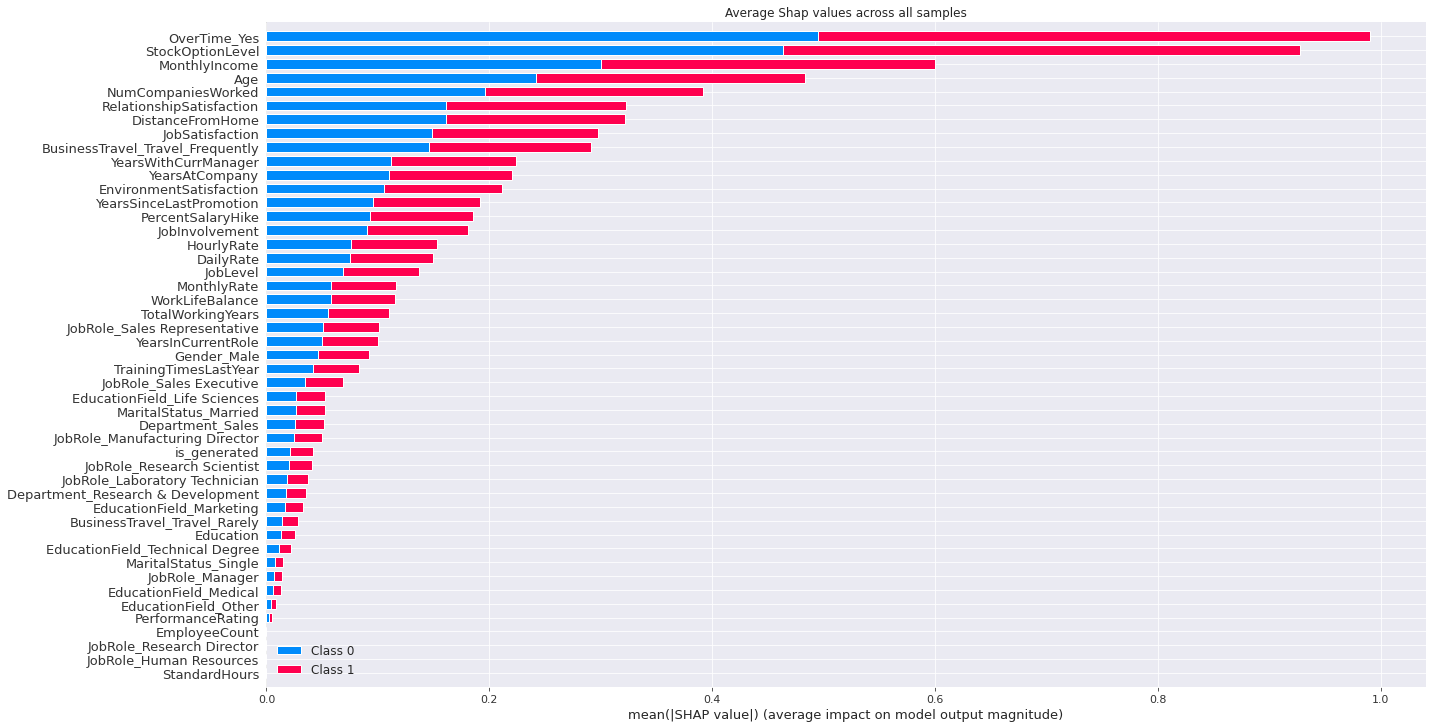

In [35]:
shap.summary_plot(shap_values, X_test_s,max_display = 400, plot_size = [20,10], show= False)
plt.title("Average Shap values across all samples")
plt.show()

#Mumltimodal testing

In [36]:
models = {
    "LogisticRegression": LogisticRegression(max_iter = 10000),
    "Ridge": RidgeClassifier(class_weight='balanced',max_iter = 10000,alpha = 0.2),
    "SVC":SVC(probability=True, kernel = "rbf",class_weight='balanced'),
     "lightgbm": lgb.LGBMClassifier(scale_pos_weight=7.385, n_estimators = 10000,early_stopping_rounds =30),  # Note: scale_pos_weight is total majoriity / total minority class ==1477/200
    "xgboost": xgb.XGBClassifier(scale_pos_weight=7.385, n_estimators = 10000,early_stopping_rounds =30), # Note: scale_pos_weight is total majoriity / total minority class ==1477/200
    "catboost": cat.CatBoostClassifier(iterations=1000, eval_metric = "AUC"),
     "ExtraTreeClassifier": ExtraTreesClassifier(),
     "RandomForestClassifier":RandomForestClassifier(class_weight = 'balanced')
}

**Cross Validation**


In [37]:
# We use Stratified Kfold due to the class imbalance
kfold= StratifiedKFold(n_splits=5)

In [38]:
test_preds =[]
train_preds = []

OOF_val_score =[]
OOF_val_loss =[]

for name,model in models.items():
    score_train = []
    score_val= []
    score_loss = []
    
    in_fold_trn_preds = []   
    in_fold_preds = []
    print("\n######",name,"######")

    for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
        X_train,y_train = X.iloc[train_idx,:], y[train_idx]
        X_test,y_test = X.iloc[val_idx,:], y[val_idx]
        
        #Scale Skewness: see distribution 
        
        test_temp = df_tst.copy(deep = True)
        X_temp = X.copy(deep = True)
        scaler = QuantileTransformer(output_distribution="normal")
        X_train[skew_cols] = scaler.fit_transform(X_train[skew_cols])
        X_test[skew_cols]  = scaler.transform(X_test[skew_cols])
        test_temp[skew_cols] = scaler.transform(df_tst[skew_cols])
        X_temp[skew_cols]  = scaler.transform(X_temp[skew_cols])

        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train[outliers] = scaler.fit_transform(X_train[outliers])
        X_test[outliers]  = scaler.transform(X_test[outliers])
        test_temp[outliers] = scaler.transform(df_tst[outliers])
        X_temp[outliers]  = scaler.transform(X_temp[outliers])
        
        #Fit
        if name in ["lightgbm", "xgboost"]:
            model.fit(X_train,y_train,
                     eval_set=[(X_test,y_test)],
                      eval_metric=["auc"],
                      verbose= 0
                     )
            
        elif name in [ "catboost"]:
            model.fit(X_train,y_train, 
                      eval_set=[(X_test,y_test)], early_stopping_rounds= 30,
                     verbose= 0)
         
        else:
            model.fit(X_train,y_train)
            
        # Predict
        if name in ["Ridge"]:
            y_preds = model.predict(X_test)
            y_trn_preds = model.predict(X_temp)
            in_fold_trn_preds.append(y_trn_preds)
            in_fold_preds.append(model.predict(test_temp))
        else:
            y_preds = model.predict_proba(X_test)[:,1]
            y_trn_preds = model.predict_proba(X_temp)[:,1]
            in_fold_trn_preds.append(y_trn_preds )
            in_fold_preds.append(model.predict_proba(test_temp)[:,1] )
        
        score_val.append(roc_auc_score(y_test,y_preds))
        score_loss.append(log_loss(y_test,y_preds))
        score_train.append(roc_auc_score(y,y_trn_preds))
    
    OOF_val_score.append(np.mean(score_val))
    OOF_val_loss.append(np.mean(score_loss))
    train_preds.append(np.mean(in_fold_trn_preds,axis=0))
    test_preds.append(np.mean(in_fold_preds,axis=0))

    print("MEAN Trn AUC:",np.mean(score_train))
    print("MEAN Val AUC:",np.mean(score_val))
    print("MEAN logloss:",np.mean(score_loss))


###### LogisticRegression ######
MEAN Trn AUC: 0.8595333834345208
MEAN Val AUC: 0.8445500140738084
MEAN logloss: 0.29582849369633324

###### Ridge ######
MEAN Trn AUC: 0.7793409442103575
MEAN Val AUC: 0.7588374841428666
MEAN logloss: 7.847629071274255

###### SVC ######
MEAN Trn AUC: 0.8073825225666443
MEAN Val AUC: 0.7985010671031476
MEAN logloss: 0.32486900513887573

###### lightgbm ######


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


MEAN Trn AUC: 0.9215404426355477
MEAN Val AUC: 0.7913329438937022
MEAN logloss: 0.3694178151727182

###### xgboost ######


divide by zero encountered in log
invalid value encountered in multiply
divide by zero encountered in log
invalid value encountered in multiply
divide by zero encountered in log
invalid value encountered in multiply


MEAN Trn AUC: 0.9733488984775432
MEAN Val AUC: 0.8206427585435729
MEAN logloss: nan

###### catboost ######
MEAN Trn AUC: 0.9423942175348528
MEAN Val AUC: 0.8546404045545157
MEAN logloss: 0.2986920847229336

###### ExtraTreeClassifier ######
MEAN Trn AUC: 0.992845212662653
MEAN Val AUC: 0.8303138266492383
MEAN logloss: 0.33284284462596403

###### RandomForestClassifier ######
MEAN Trn AUC: 0.9871882256580002
MEAN Val AUC: 0.832554309477264
MEAN logloss: 0.3146041133591507


**Submission**

In [39]:
sub["Attrition"]  = 0
sub_ensemble = sub.copy(deep= True)
sub_best_cv = sub.copy(deep= True)

In [40]:
# Base model submission
sub[target]=test_base
print("Base Model (lightgbm) values (inital 5 rows):")
sub.to_csv("submission_base.csv")
sub.head()

Base Model (lightgbm) values (inital 5 rows):


,Attrition
id,
1677,0.237647
1678,0.072196
1679,0.039720
1680,0.063211
1681,0.435251
